<a href="https://colab.research.google.com/github/joaoflauzino/handsOn_Machine_Learning/blob/main/HandsOn_GI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Manipulação de dados
import pandas as pd
import numpy as np 

# Arquivos
from google.colab import files
from google.colab import drive

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn import linear_model 
import sklearn

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as pipe_imb 


# Pré-Processamento
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Avaliação
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Visualização de dados
import seaborn as sns 
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Problema

* Cenário de transações bancárias
* Muitos eventos de fraudes ocorrendo sem ação rápida para trativas

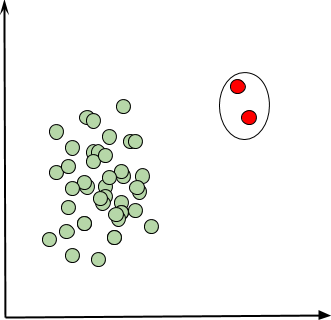

# Objetivo

* Ensinar a máquina para identificar fraude sem a necessidade de intervenção humana

# Descrição da base

- type -> CASH-IN (Depósito), CASH-OUT (Saque), DEBIT (Débito), PAYMENT (Pagamentos) e TRANSFER (Transferências)
- amount -> Valor da transação financeira
- nameOrig -> Cliente que iniciou a operação
- oldbalanceOrg -> Balanço inicial antes da transação
- newbalanceOrig -> Balanço atualizado após a transação
- nameDest -> cliente que recebeu o valor da transação
- oldbalanceDest -> Balanço inicial do cliente de destino que recebeu a transação
- newbalanceDest  -> Balanço atualizado do cliente de destino após a transação
- isFraud -> Marcação de qual transação é fraude
- IsFlaggedFraud -> Marcação realizada por um processo de negócios qualquer


# Leitura da base

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Datasets/Fraud.csv')

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.shape

(6362620, 11)

# Exploração

In [ ]:
# Definir numero casas decimais
pd.set_option('float_format', '{:.2f}'.format)

In [ ]:
# Estatisticas básicas
df.describe()

# 25% dos dados de transações estão abaixo de 13 mil
# 50% dos dados estão abaixo de 74 mil
# 75% dos dados estão abaixo 208 mil

# Média de 179.861 reais em transações
# Desvio padrão de 603 mil em transações
# Altos indicios de outliers

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [ ]:
# Verificar valores nulos
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
# Distribuição da Target
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
# Distribuição da Target de negócios
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
# Realizando cópia do dataframe
df_new = df.copy()

In [ ]:
# Cabeçalho do dataframe
df_new.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [ ]:
# Em que casos conseguimos identificar fraude? Quando isso acontece? Existe algum padrão no destino das operações?
df_new['nameDest'].head()

0    M1979787155
1    M2044282225
2     C553264065
3      C38997010
4    M1230701703
Name: nameDest, dtype: object

In [ ]:
# Criando lógia para identificar pessoa física e empresa
df_new['type1'] = ''

df_new.loc[ df_new.nameOrig.str.contains('C') & df_new.nameDest.str.contains('C'), "type1"] = "CC" 
df_new.loc[ df_new.nameOrig.str.contains('C') & df_new.nameDest.str.contains('M'), "type1"] = "CM"
df_new.loc[ df_new.nameOrig.str.contains('M') & df_new.nameDest.str.contains('C'), "type1"] = "MC"
df_new.loc[ df_new.nameOrig.str.contains('M') & df_new.nameDest.str.contains('M'), "type1"] = "MM"

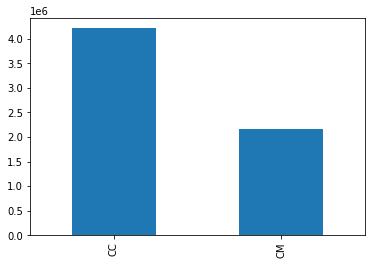

In [ ]:
df_new['type1'].value_counts().plot.bar()

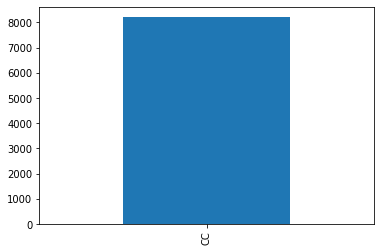

In [ ]:
# Tipo de conta que mais realiza fraude
df_new[ df_new['isFraud'] == 1]['type1'].value_counts().plot.bar()

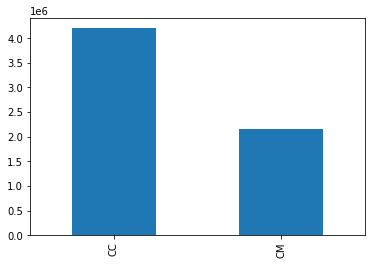

In [ ]:
# Tipo de conta que não realiza fraude
df_new[ df_new['isFraud'] == 0]['type1'].value_counts().plot.bar()

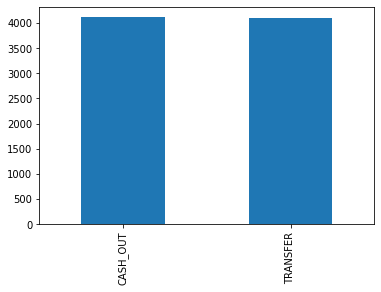

In [ ]:
# Em quais tipos de transações ocorrem fraudes?
df_new[df_new['isFraud'] == 1]['type'].value_counts().plot.bar()

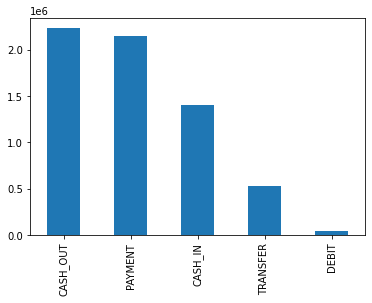

In [ ]:
# Em quais tipos de transação não ocorre fraude
df_new[df_new['isFraud'] == 0]['type'].value_counts().plot.bar()

In [ ]:
# Será que o cara que realiza fraude sempre utiliza a mesma conta?
max(df_new[ df_new['isFraud'] == 1]['nameOrig'].value_counts())

1

In [ ]:
# Será que o cara que recebe a fraude sempre utiliza a mesma conta?
max(df_new[ df_new['isFraud'] == 1]['nameDest'].value_counts())

2

In [ ]:
# Qual o valor antigo do balanço do destino que mais repete quando eu tenho fraude
df_new[ df_new['isFraud'] == 1  ]['oldbalanceDest'].mode()

0   0.00
dtype: float64

- Citar análise bivariada como possível alternativa (Não vai dar tempo de falar no curso)

# Preparar os dados para rodar modelos

In [ ]:
df_new = df_new.drop(['nameOrig', 'nameDest', 'type1', 'step', 'isFlaggedFraud'], axis = 1)

In [ ]:
df_new.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0


## Iniciando abordagem do modelo supervisionado

In [ ]:
# Variaveis independentes (Variáveis que vão tentar realizar a explicação)
X = df_new[ [i for i in df_new.columns if i != 'isFraud'] ]

In [ ]:
# Variável dependente (Variável Alvo)
y = df_new['isFraud']

# Criando Pipelines

In [ ]:
# Pipeline para aplicar undersample
undersample_transformer = pipe_imb(steps=[
        ('UndersampleTransformer', RandomUnderSampler())
        ])


# Capturando variáveis numéricas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = [i for i in X.select_dtypes(include=numerics) if i != 'type']

# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps=[
        ('MinMaxScaler', MinMaxScaler())
        ])

# Capturando variáveis categóricas
categorical_features = ['type']

# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder(handle_unknown = "ignore"))
])


# Concatenando pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])


# Algoritmos escolhidos
algorithms = [tree.DecisionTreeClassifier(), 
              sklearn.ensemble.GradientBoostingClassifier(), 
              sklearn.ensemble.RandomForestClassifier()]

# Aplicando UnderSample e dividindo em treino e teste

In [ ]:
# Aplicando undersample
X_resampled, y_resampled = undersample_transformer.fit_resample(X,y)
# Transformando em dataframe
X_resampled_renamed = pd.DataFrame(X_resampled, columns=X.columns)
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled_renamed, y_resampled, test_size=0.30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Aplicando pipeline

In [ ]:
%%time
# Pipeline final
modelos = {}
for alg in algorithms:
  # Criando passo a passo
  setps_ = [('preprocessor', preprocessor), ('models', alg)]
  # Criando pipeline
  model = Pipeline(steps=setps_)
  # Treinando o modelo
  model.fit(X_train, y_train)
  # Testando o modelo
  y_pred = model.predict(X_test)
  # Armazenando resultados
  modelos[alg.__class__.__name__] = {}
  modelos[alg.__class__.__name__]['ROC'] = roc_auc_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['PRECISAO'] = precision_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['RECALL'] = recall_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['F1_SCORE'] = f1_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['MATRIZ_CONFUSAO'] = confusion_matrix(y_test, y_pred)

CPU times: user 3.67 s, sys: 21.9 ms, total: 3.69 s
Wall time: 3.71 s


# Avaliando Resultados


- Entendendo a matriz de confusão

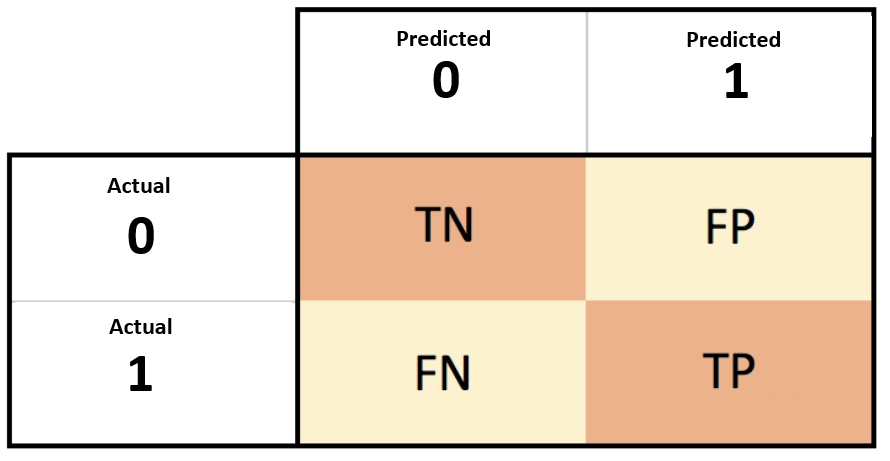

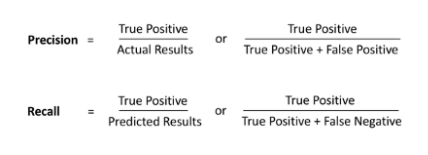

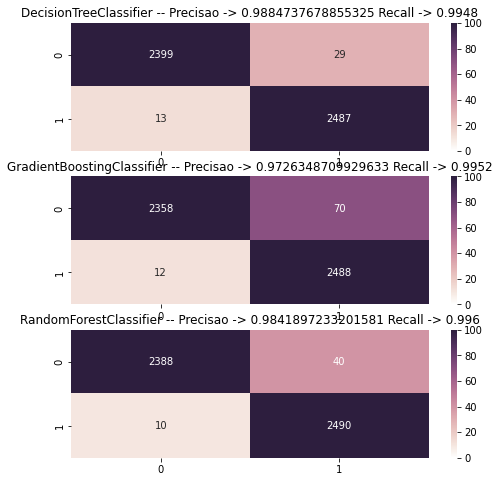

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(nrows=len(algorithms), figsize=(8,8))

for indice, alg in enumerate(algorithms):
  sns.heatmap(modelos[alg.__class__.__name__]['MATRIZ_CONFUSAO'], annot=True, vmin=0.0, vmax=100.0, fmt='.0f', cmap=cmap, ax = axs[indice])
  axs[indice].set_title(f'{alg.__class__.__name__} -- Precisao -> {modelos[alg.__class__.__name__]["PRECISAO"]} Recall -> {modelos[alg.__class__.__name__]["RECALL"]}')

## Overfitting e Underfitting


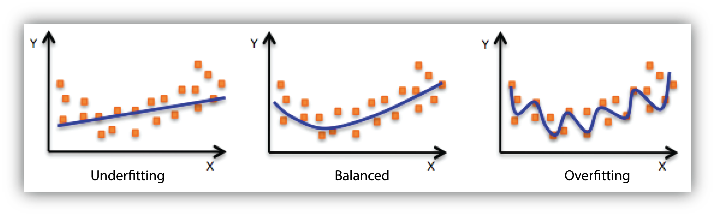
